In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/DATASET/TESS Toronto emotional speech set data'

In [ ]:
# Initialize empty lists for features and labels
features = []
labels = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                # Load the audio file and extract features
                audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)

In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
# Define the emotions and the number of samples to select from each emotion
emotions = ['angry', 'disgust', 'Fear', 'happy', 'neutral', 'Sad']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []

In [ ]:
# Iterate through the emotions and select samples
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)

    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))


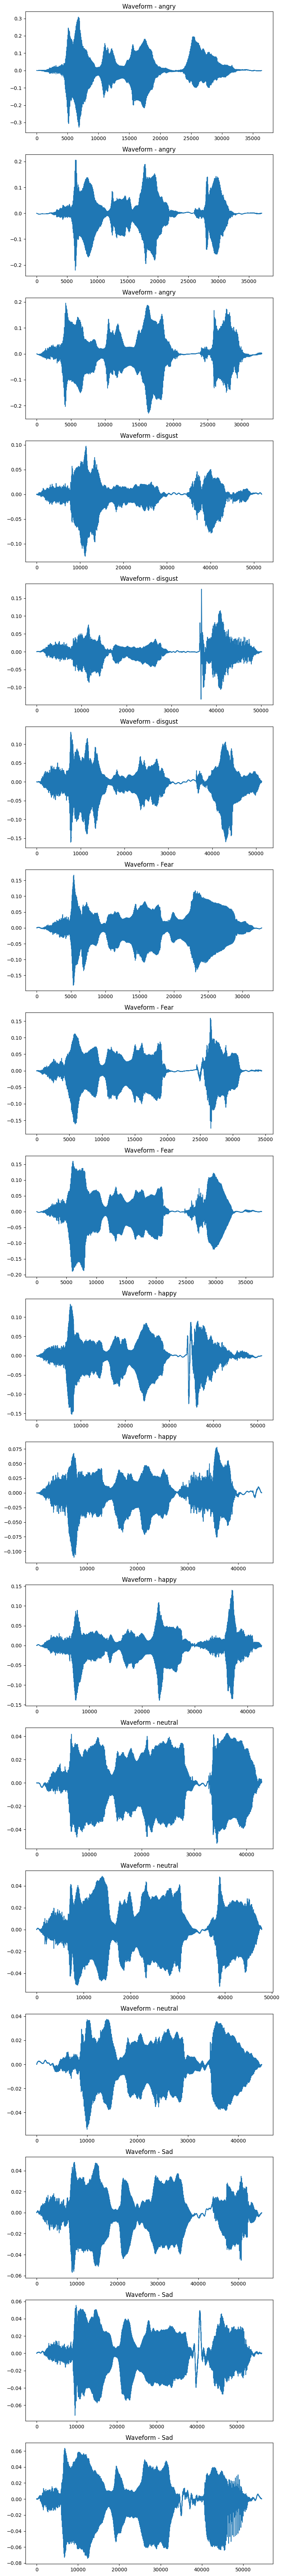

In [ ]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()


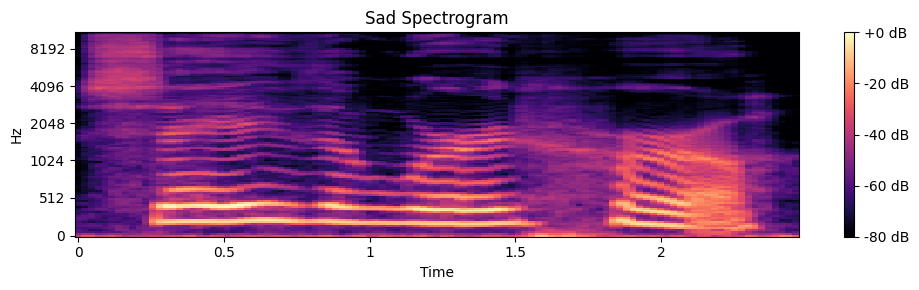

In [ ]:
# Calculate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert power spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sad Spectrogram')
plt.tight_layout()
plt.show()
Audio(file_path)

In [ ]:
# Define a list to store the preprocessed data
preprocessed_data = []
file_list = os.listdir(data_dir)
# Iterate over the files
for filename in file_list:
    file_path = os.path.join(data_dir, filename)

    # Skip non-audio files
    if not filename.endswith('.wav'):
        continue

    # Load the audio file and obtain the waveform and sample rate
    waveform, sr = librosa.load(file_path, sr=None, dtype=np.float32)

    # Resample the audio if needed
    if sr != 22050:
        waveform = librosa.resample(waveform, sr, 22050)
        sr = 22050


In [ ]:
# Encode the emotion labels
label_mapping = {'angry': 0, 'disgust': 1, 'Fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != 1)[0]  # Get the indices from the tuple
features = features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


##CNN


In [ ]:
#Build the cnn model architeture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=( 13, 1, 1), padding='same'))

# Flatten the output
model.add(Flatten())

# Add a dense layer0
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 13, 1, 32)         320       
                                                                 
 flatten_9 (Flatten)         (None, 416)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                13344     
                                                                 
 dense_19 (Dense)            (None, 6)                 198       
                                                                 
Total params: 13862 (54.15 KB)
Trainable params: 13862 (54.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/15
30/30 [==============================] - 2s 10ms/step - loss: 3.1873 - accuracy: 0.3500 - val_loss: 1.3059 - val_accuracy: 0.4604
Epoch 2/15
30/30 [==============================] - 0s 4ms/step - loss: 1.0926 - accuracy: 0.5344 - val_loss: 0.9318 - val_accuracy: 0.6271
Epoch 3/15
30/30 [==============================] - 0s 4ms/step - loss: 0.8609 - accuracy: 0.6911 - val_loss: 0.7498 - val_accuracy: 0.7458
Epoch 4/15
30/30 [==============================] - 0s 4ms/step - loss: 0.7054 - accuracy: 0.7833 - val_loss: 0.6491 - val_accuracy: 0.8042
Epoch 5/15
30/30 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.8089 - val_loss: 0.5766 - val_accuracy: 0.8104
Epoch 6/15
30/30 [==============================] - 0s 4ms/step - loss: 0.5366 - accuracy: 0.8344 - val_loss: 0.5044 - val_accuracy: 0.8250
Epoch 7/15
30/30 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.8333 - val_loss: 0.4593 - val_accuracy: 0.8271
Epoch 8/15
30/30 [=

##TEST ACCURACY

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

15/15 [==============================] - 0s 7ms/step - loss: 0.3244 - accuracy: 0.8792
Accuracy of our model on test data :  87.91666626930237 %


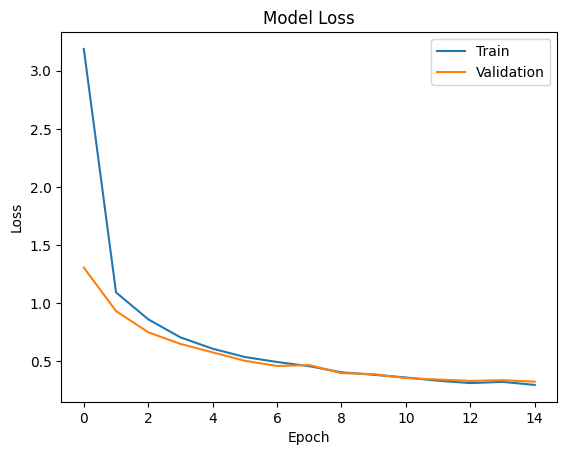

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

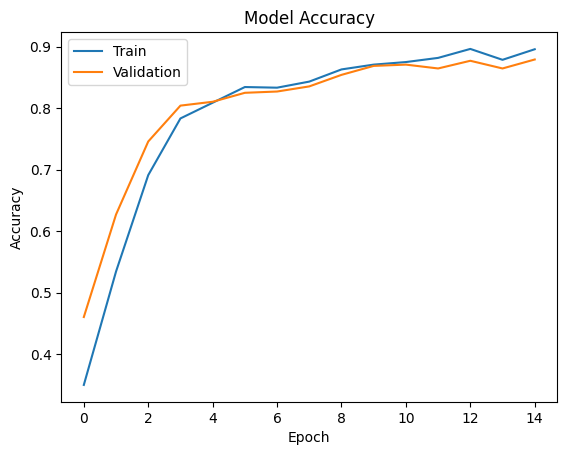

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

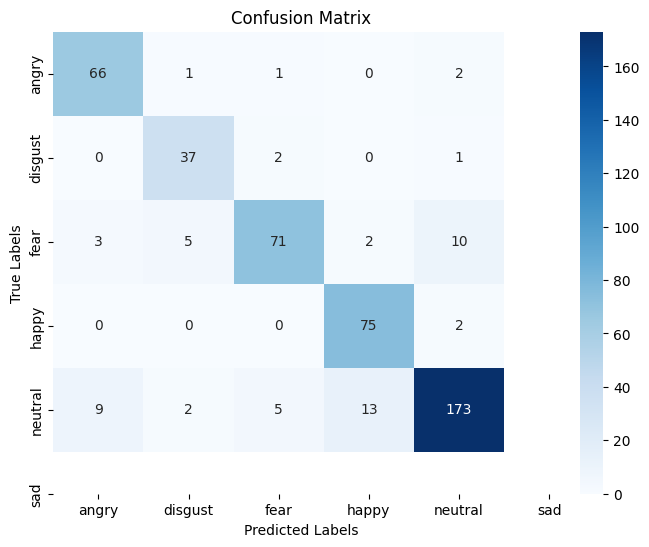

In [ ]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(report)

              precision    recall  f1-score   support

       angry       0.85      0.94      0.89        70
     disgust       0.00      0.00      0.00         0
        fear       0.82      0.93      0.87        40
       happy       0.90      0.78      0.84        91
     neutral       0.83      0.97      0.90        77
         sad       0.92      0.86      0.89       202

   micro avg       0.88      0.88      0.88       480
   macro avg       0.72      0.75      0.73       480
weighted avg       0.88      0.88      0.88       480



In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=64)

Epoch 1/10
21/21 [==============================] - 0s 6ms/step - loss: 0.2695 - accuracy: 0.9122 - val_loss: 0.3005 - val_accuracy: 0.8993
Epoch 2/10
21/21 [==============================] - 0s 4ms/step - loss: 0.2629 - accuracy: 0.9100 - val_loss: 0.2989 - val_accuracy: 0.8976
Epoch 3/10
21/21 [==============================] - 0s 5ms/step - loss: 0.2704 - accuracy: 0.9085 - val_loss: 0.2627 - val_accuracy: 0.9149
Epoch 4/10
21/21 [==============================] - 0s 4ms/step - loss: 0.2658 - accuracy: 0.9062 - val_loss: 0.2634 - val_accuracy: 0.8976
Epoch 5/10
21/21 [==============================] - 0s 8ms/step - loss: 0.2473 - accuracy: 0.9085 - val_loss: 0.2482 - val_accuracy: 0.9201
Epoch 6/10
21/21 [==============================] - 0s 9ms/step - loss: 0.2585 - accuracy: 0.9033 - val_loss: 0.3430 - val_accuracy: 0.8646
Epoch 7/10
21/21 [==============================] - 0s 8ms/step - loss: 0.2550 - accuracy: 0.9025 - val_loss: 0.2462 - val_accuracy: 0.9184
Epoch 8/10
21/21 [==

##TRAIN ACCURACY

In [ ]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model

model.save('/content/SER_model_weights.h5')  # Ensure the file path is correct
print("Saved model to disk")

# Load the trained model
model = load_model('/content/SER_model_weights.h5')
# Function to preprocess audio
def preprocess_audio(audio_path):
    # Load audio file and extract features (e.g., MFCCs)
    audio, _ = librosa.load(audio_path, sr=175)
    mfccs = librosa.feature.mfcc(y=audio, sr=175, n_mfcc=13)

    # Reshape data for CNN input
    mfccs = mfccs[np.newaxis, ..., np.newaxis]
    return mfccs

# Path to your recorded audio file
your_audio_path = '/content/drive/MyDrive/DATASET/TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav'

# Preprocess the audio
input_data = preprocess_audio(your_audio_path)

# Predict emotion
predictions = model.predict(input_data)
predicted_emotion = np.argmax(predictions)

# Map predicted emotion index to emotion label
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'Sad']
predicted_emotion_label = emotion_labels[predicted_emotion]

print('Predicted Emotion:', predicted_emotion_label)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=245
  warnings.warn(


Saved model to disk
1/1 [==============================] - 0s 86ms/step
Predicted Emotion: Sad
